In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('./dataset/UWB-LOS-NLOS-Data-Set/dataset/uwb_dataset_part1.csv')
df2 = pd.read_csv('./dataset/UWB-LOS-NLOS-Data-Set/dataset/uwb_dataset_part2.csv')
df3 = pd.read_csv('./dataset/UWB-LOS-NLOS-Data-Set/dataset/uwb_dataset_part3.csv')
df4 = pd.read_csv('./dataset/UWB-LOS-NLOS-Data-Set/dataset/uwb_dataset_part4.csv')
df5 = pd.read_csv('./dataset/UWB-LOS-NLOS-Data-Set/dataset/uwb_dataset_part5.csv')
df6 = pd.read_csv('./dataset/UWB-LOS-NLOS-Data-Set/dataset/uwb_dataset_part6.csv')
df7 = pd.read_csv('./dataset/UWB-LOS-NLOS-Data-Set/dataset/uwb_dataset_part7.csv')

combined_df = pd.concat([df, df2, df3, df4, df5, df6, df7])

In [2]:
new_df = combined_df.drop(['MAX_NOISE','CH','FRAME_LEN','PREAM_LEN','BITRATE','PRFR'], axis=1)

1. CIR_PEAK_VALUE: This feature captures the highest signal strength recorded within the CIR measurements for each observation. The peak value is important as it often corresponds to the most significant direct path or reflection in the channel impulse response. In the context of LOS/NLOS classification, a higher peak might be associated with a clear LOS, while a lower peak could suggest an NLOS scenario with more multipath effects.

2. CIR_PEAK_INDEX: The index of the peak value can provide temporal information about when the peak occurred. This is directly related to the propagation delay of the signal. For example, a smaller index (earlier time) for the peak value might indicate a LOS condition, where the signal travels directly from the transmitter to the receiver, whereas a peak occurring later might suggest reflections and thus an NLOS condition.

3. CIR_ENERGY_SUM: By summing all CIR measurements, this feature represents the total energy of the signal's impulse response. It gives a sense of the overall power captured by the receiver and can be indicative of the combined effect of the direct path and any reflections. In indoor localization, different environments might display distinct total energy profiles, which could help distinguish between LOS and NLOS states.

4. CIR_EARLY_ENERGY: This feature is the sum of the first N CIR measurements (with N=100 in your example), focusing on the early part of the signal. The early energy is likely to be influenced primarily by the LOS component before the signal has had much chance to reflect off objects. Therefore, it might be expected to be larger in LOS situations compared to NLOS.

In [3]:
cir_columns = new_df.filter(regex='^CIR[0-9]+$').columns

# Peak Value and Index
new_df['CIR_PEAK_VALUE'] = new_df.filter(regex='CIR').max(axis=1)
new_df['CIR_PEAK_INDEX'] = df[cir_columns].idxmax(axis=1).str.extract('(\d+)').astype(int)

# Energy Sum
new_df['CIR_ENERGY_SUM'] = new_df.filter(regex='CIR').sum(axis=1)

# Early Reflections: Calculate the sum of the first N CIR measurements. Let's say N=100 for this example
N = 100
early_cir_columns = ['CIR{}'.format(i) for i in range(N)]
new_df['CIR_EARLY_ENERGY'] = new_df[early_cir_columns].sum(axis=1)

# Display the new features to verify
new_df[['CIR_PEAK_VALUE', 'CIR_PEAK_INDEX', 'CIR_ENERGY_SUM', 'CIR_EARLY_ENERGY']].head()

,CIR_PEAK_VALUE,CIR_PEAK_INDEX,CIR_ENERGY_SUM,CIR_EARLY_ENERGY
0,23077.0,748,437229.0,22550.0
1,18968.0,757,489858.0,20796.0
2,16809.0,754,543803.0,21061.0
3,15742.0,756,444909.0,26896.0
4,19583.0,750,400884.0,21277.0


1. Mean (CIR_MEAN): This would calculate the average value of the CIR measurements across each row, giving an overall sense of the central tendency of the CIR values.

2. Variance (CIR_VARIANCE): This would compute the variance of the CIR measurements for each row, which tells you how much the values are spread out from the mean.

3. Skewness (CIR_SKEWNESS): This measures the asymmetry of the probability distribution of the CIR measurements. A distribution, or a set of values, that is asymmetrically distributed will have a skewness not equal to zero.

4. Kurtosis (CIR_KURTOSIS): This measures the 'tailedness' of the probability distribution of the CIR measurements. A high kurtosis may indicate data with heavy tails or outliers.

In [4]:
new_df['CIR_MEAN'] = new_df[cir_columns].mean(axis=1)
new_df['CIR_VARIANCE'] = new_df[cir_columns].var(axis=1)

# Skewness and Kurtosis
new_df['CIR_SKEWNESS'] = new_df[cir_columns].skew(axis=1)
new_df['CIR_KURTOSIS'] = new_df[cir_columns].kurtosis(axis=1)

# Display the new statistical features to verify
new_df[['CIR_MEAN', 'CIR_VARIANCE', 'CIR_SKEWNESS', 'CIR_KURTOSIS']].head()

,CIR_MEAN,CIR_VARIANCE,CIR_SKEWNESS,CIR_KURTOSIS
0,395.225394,1.503746e+06,10.561181,145.680415
1,444.060039,2.665030e+06,8.523565,77.420815
2,503.485236,1.859169e+06,7.101177,58.677750
3,413.054134,1.097226e+06,9.486008,106.180924
4,363.357283,1.438949e+06,11.789746,152.210034


In [5]:
from sklearn.ensemble import RandomForestClassifier

X = new_df.drop('NLOS', axis=1)
y = new_df['NLOS']

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf_classifier.fit(X, y)

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame based on feature importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 20 most important features
feature_importance_df.head(20)

,Feature,Importance
7,RXPACC,0.092568
1024,CIR_PEAK_VALUE,0.048131
4,FP_AMP3,0.030837
6,CIR_PWR,0.030421
1029,CIR_VARIANCE,0.030002
0,RANGE,0.028830
3,FP_AMP2,0.022539
1027,CIR_EARLY_ENERGY,0.016419
2,FP_AMP1,0.012551
749,CIR741,0.010311


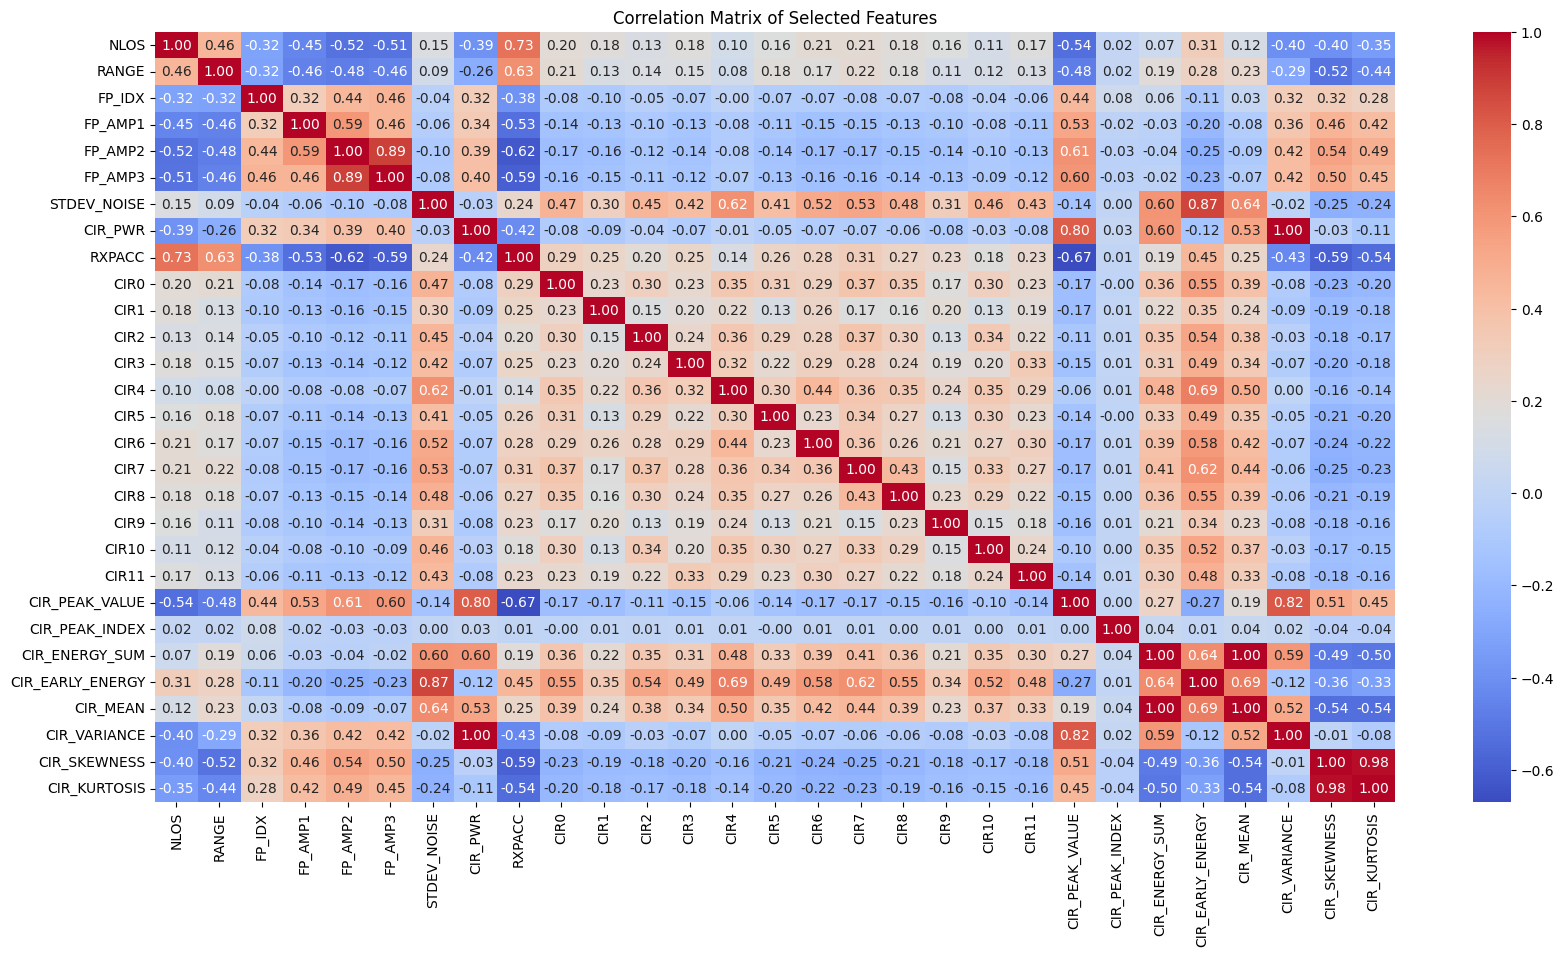

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

selected_features = new_df.columns[:21]
selected_features = selected_features.append(new_df.columns[-8:])
correlation_matrix = new_df[selected_features].corr()

# Plotting the correlation heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Selected Features')
plt.show()

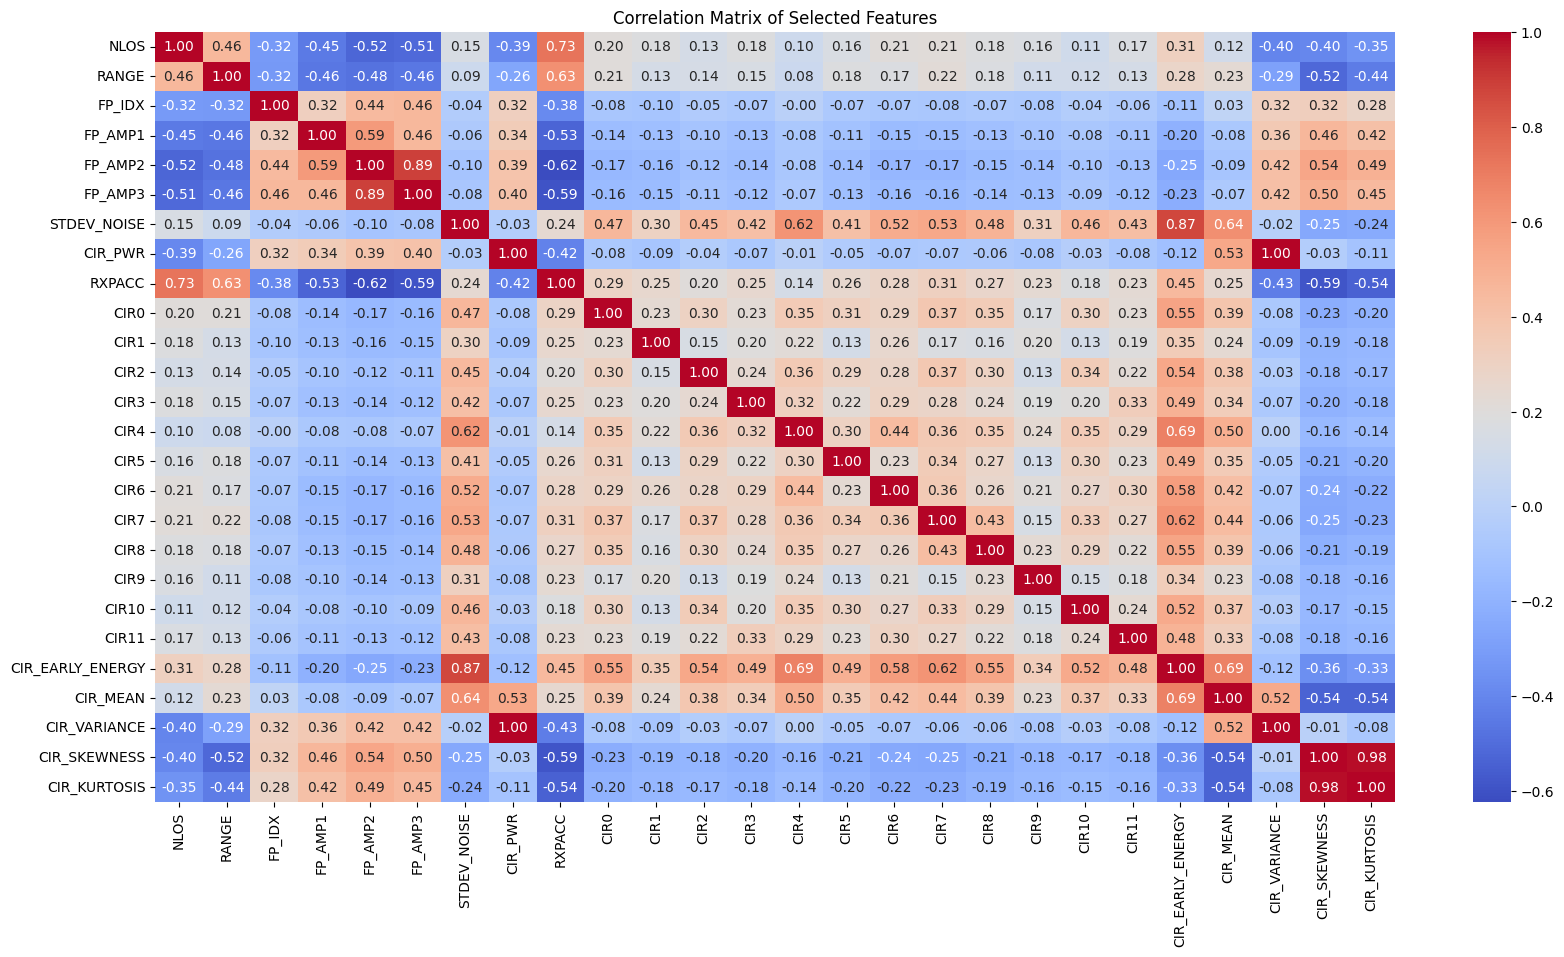

In [7]:
new_df.describe()
new_df.drop(['CIR_PEAK_INDEX','CIR_ENERGY_SUM','CIR_MEAN'], axis=1)

selected_features = new_df.columns[:21]
selected_features = selected_features.append(new_df.columns[-5:])
correlation_matrix = new_df[selected_features].corr()

# Plotting the correlation heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Selected Features')
plt.show()

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardizing the data
scaler = StandardScaler()
X = new_df
X_scaled = scaler.fit_transform(X)

# Applying PCA
pca = PCA(n_components=0.95) # Keep 95% of the variance
X_pca = pca.fit_transform(X_scaled)

# The amount of variance that each principal component explains
variance_explained = pca.explained_variance_ratio_

# The cumulative variance explained by the principal components
cumulative_variance_explained = np.cumsum(variance_explained)

# The number of components
num_components = pca.n_components_

(num_components, cumulative_variance_explained)

(868,
 array([0.21479201, 0.25770343, 0.27712987, 0.29288195, 0.30211843,
        0.31066279, 0.31762503, 0.32303576, 0.32815711, 0.33285567,
        0.33678805, 0.34012595, 0.34336107, 0.34609555, 0.34878615,
        0.35119323, 0.35350836, 0.35573454, 0.35768032, 0.35954712,
        0.36130808, 0.3629769 , 0.36454397, 0.36610558, 0.36761618,
        0.36901534, 0.37039469, 0.37174523, 0.37306731, 0.37437529,
        0.37563799, 0.37689949, 0.37813516, 0.37935751, 0.38057436,
        0.38174516, 0.38291135, 0.38404959, 0.38518307, 0.38630687,
        0.38741487, 0.38851957, 0.38961459, 0.39069905, 0.39177891,
        0.39285121, 0.39391848, 0.39498161, 0.39603872, 0.39709222,
        0.39814328, 0.39918583, 0.40022287, 0.40125712, 0.40228835,
        0.40331629, 0.40433991, 0.40535986, 0.40637896, 0.40739427,
        0.40840487, 0.40941389, 0.41041996, 0.41141985, 0.41241829,
        0.4134147 , 0.41441036, 0.41540277, 0.41639106, 0.41737805,
        0.41836354, 0.41934416, 0.42032394